<a href="https://colab.research.google.com/github/antagonisuto/CliqueAndSepsetBelief/blob/master/AAI_MN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov Network Project  
Done by Madina Saparbayeva  

2 - Implement a feature selector based on minimization of graph size. In this work you will get a dataset and your task is to implement a graph building and optimizing tools that will determine what size and what independencies should be included into a target undirected graphical model.

* For a given set of features (medical pyradiomycs, region props, etc) you will construct a Markov Network
* This implies that you will determine an initial set of independencies and use the final evaluation as a measure if more or less features should be included and how
* You can use a standard approach such as described in the first project or you can do a model search





In [ ]:
#!pip install pyradiomics

# Data Representation

In [ ]:
import os  # needed navigate the system to get the input data

#import radiomics  # This module is used for interaction with pyradiomics
#from radiomics import featureextractor

import pandas as pd
import numpy as np
#import SimpleITK as sitk


In [ ]:
#change the directory
data = pd.read_csv('/content/drive/MyDrive/AAI_Dataset/features_all_images.csv')

#change the directory for labels
data_label = pd.read_csv('/content/drive/MyDrive/AAI_Dataset/labels.csv')
data_label_to_check = data_label

#find the max value from four algorithms
values = ['chexnet', 'resnet', 'unet', 'cnn']
data_label_max = data_label
data_label['label'] = data_label_max[values].idxmax(axis=1)
data_label = data_label.drop(values, axis=1)

#merge two tables
data_all = pd.merge(data, data_label, left_on=data.columns[0], right_on=data_label.columns[0], how='left').dropna()

#drop the id of patients
data_all = data_all.drop({data_all.columns[0], data_all.columns[1], 'patientId'}, axis = 1)
data_all

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares,...,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,label
3,47.0,170.0,8.542779e+08,2.830793,72.0,2.030760,208.0,37.985648,107.469541,105.0,5.0,203.0,29.308195,116.459289,0.051195,8.542779e+08,0.148202,2013.063653,26.306327,4.803740,351.816310,2.213992,13.037133,0.115547,0.982428,0.115547,0.514684,0.101951,0.116897,3.445256,-0.781759,0.993931,0.942226,0.998591,0.942226,0.988445,0.115547,0.164740,3.329709,3.288170,...,0.085548,7.097421,600.617293,0.075759,0.123903,75.219888,0.228506,6.068171,0.019824,45.896755,0.135389,4.294011,26.486726,7.834681e+05,1.957291e+07,51971.331670,0.119705,80.463127,0.237354,0.503683,14.318068,0.047261,5.793842,0.005382,7.489456e+05,4.690671,26303.842396,0.417607,2.470734,9334.780875,3.303610,26.525092,66.611285,1777.871656,5.461829,0.082584,0.022018,0.587565,0.001880,resnet
6,27.0,154.0,5.795379e+08,2.788896,71.0,2.150118,189.0,38.999068,81.618274,73.0,0.0,189.0,29.913309,93.724798,0.456193,5.795379e+08,0.157639,2122.795050,17.432819,3.754122,399.375761,22.372819,13.506009,0.148585,0.978228,0.148317,0.604096,0.126121,0.117876,3.511171,-0.737259,0.991584,0.925868,0.997714,0.925886,0.983523,0.148083,0.200114,3.361322,3.413648,...,0.166678,6.769185,963.284876,0.092230,0.155417,47.546350,0.246662,5.167638,0.041238,53.173913,0.135995,5.219157,20.994885,7.753587e+05,1.106673e+07,107513.847935,0.249582,70.278772,0.179741,0.433164,9.689861,0.095437,6.1

In [ ]:
data_all.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares,...,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,label
3,47.0,170.0,8.542779e+08,2.830793,72.0,2.030760,208.0,37.985648,107.469541,105.0,5.0,203.0,29.308195,116.459289,0.051195,8.542779e+08,0.148202,2013.063653,26.306327,4.803740,351.816310,2.213992,13.037133,0.115547,0.982428,0.115547,0.514684,0.101951,0.116897,3.445256,-0.781759,0.993931,0.942226,0.998591,0.942226,0.988445,0.115547,0.164740,3.329709,3.288170,...,0.085548,7.097421,600.617293,0.075759,0.123903,75.219888,0.228506,6.068171,0.019824,45.896755,0.135389,4.294011,26.486726,7.834681e+05,1.957291e+07,51971.331670,0.119705,80.463127,0.237354,0.503683,14.318068,0.047261,5.793842,0.005382,7.489456e+05,4.690671,26303.842396,0.417607,2.470734,9334.780875,3.303610,26.525092,66.611285,1777.871656,5.461829,0.082584,0.022018,0.587565,0.001880,resnet
6,27.0,154.0,5.795379e+08,2.788896,71.0,2.150118,189.0,38.999068,81.618274,73.0,0.0,189.0,29.913309,93.724798,0.456193,5.795379e+08,0.157639,2122.795050,17.432819,3.754122,399.375761,22.372819,13.506009,0.148585,0.978228,0.148317,0.604096,0.126121,0.117876,3.511171,-0.737259,0.991584,0.925868,0.997714,0.925886,0.983523,0.148083,0.200114,3.361322,3.413648,...,0.166678,6.769185,963.284876,0.092230,0.155417,47.546350,0.246662,5.167638,0.041238,53.173913,0.135995,5.219157,20.994885,7.753587e+05,1.106673e+07,107513.847935,0.249582,70.278772,0.179741,0.433164,9.689861,0.095437,6.1

In [ ]:
first_order = data_all.loc[:, data_all.columns.str.startswith('original_firstorder_')]
glcm = data_all.loc[:, data_all.columns.str.startswith('original_glcm_')]
glrlm = data_all.loc[:, data_all.columns.str.startswith('original_glrlm_')]
glszm = data_all.loc[:, data_all.columns.str.startswith('original_glszm_')]
gldm = data_all.loc[:, data_all.columns.str.startswith('original_gldm_')]
label = data_all.loc[:, data_all.columns.str.startswith('label')]

In [ ]:
#first_order.info()
#glcm.info()
#glrlm.info()
#glszm.info()
#gldm.info()
#Uncomment this to see the info about tables
label.describe()

,label
count,2500
unique,4
top,chexnet
freq,1854


In [ ]:
#Lets take one column from each features
#first_order_node = first_order['original_firstorder_Uniformity']
#glcm_node = glcm['original_glcm_MaximumProbability']
#glrlm_node = glrlm['original_glrlm_GrayLevelNonUniformityNormalized']
#glszm_node = glszm['original_glszm_SizeZoneNonUniformityNormalized']
#gldm_node = gldm['original_gldm_DependenceNonUniformityNormalized']

In [ ]:
# nodes = pd.DataFrame()
# nodes['first_order'] = first_order_node
# nodes['glcm'] = glcm_node
# nodes['glrlm'] = glrlm_node
# nodes['glszm'] = glszm_node
# nodes['gldm'] = gldm_node

In [ ]:
corr_matrix = data_all.corr()
corr_matrix.head()
#nodes.first_order.sum()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares,...,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
original_firstorder_10Percentile,1.000000,0.473687,0.720622,-0.635462,-0.616039,0.153060,-0.007629,-0.669274,0.917562,0.920082,0.912919,-0.642341,-0.639894,0.860020,-0.652205,0.720622,0.585583,-0.669476,0.033443,0.144609,-0.652386,-0.674631,-0.663605,-0.480236,-0.447698,-0.487728,-0.491776,-0.482106,0.591847,-0.640055,-0.115844,-0.484664,0.488778,-0.214067,0.489241,0.207872,-0.491023,0.477807,-0.640665,-0.664368,...,-0.019897,-0.253294,-0.087089,-0.389641,-0.435162,-0.489282,0.452213,-0.362437,-0.341468,-0.274869,0.018524,0.597668,-0.694465,-0.224146,0.490927,0.545938,-0.000255,-0.257426,-0.341284,-0.197951,-0.216173,-0.255880,-0.306046,-0.345841,-0.322453,0.495156,-0.625297,0.378910,0.491977,-0.498375,0.458826,-0.667981,0.023812,0.488724,0.142819,-0.405826,-0.442606,-0.484336,-0.228313,-0.502369
original_firstorder_90Percentile,0.473687,1.000000,0.779636,0.344881,0.352313,-0.108376,0.750952,0.328364,0.759191,0.687247,0.369481,0.226410,0.342969,0.837415,-0.290133,0.779636,-0.350102,0.317435,0.602192,0.596804,0.255787,-0.121896,0.324890,0.116107,0.350459,0.119285,0.117602,0.116110,-0.320035,0.309862,-0.160139,0.348804,-0.119790,0.239575,-0.120073,0.040533,0.121208,-0.364778,0.320863,0.324240,...,-0.277187,-0.397396,0.216657,0.090547,-0.022971,0.120053,-0.119876,-0.146856,0.332572,

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt 

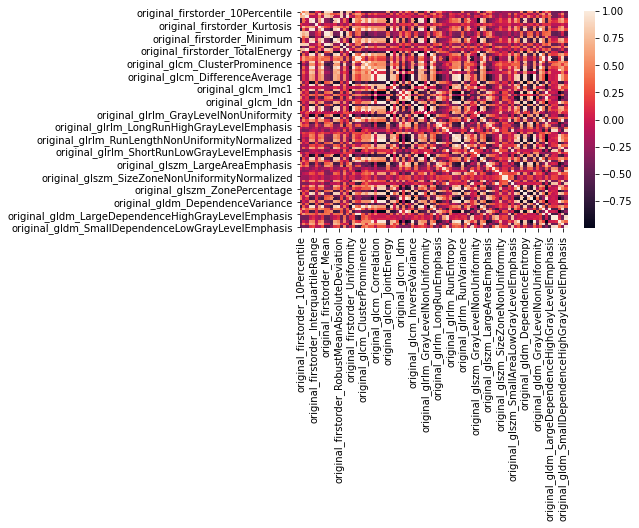

In [ ]:
sn.heatmap(corr_matrix, annot=False)
plt.show()
#light = positive, dark = negative 

In [ ]:
#likelihood of all data
data_dist = data_all.drop('label', axis='columns')
data_sum = data_dist.sum()

data_dist = data_dist.loc[:, data_dist.min(axis=0) >= 0] # 2500 rows × 83 columns (not 86 columns)

data_dist_normalized = pd.DataFrame()

for each in data_dist:
  data_dist_normalized[each] = data_dist[each] / data_sum[each]

data_dist
data_dist_normalized.describe()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,...,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,4.000000e-

#Markov Model

## Joint probability distribution of the Markov random field
In the next cell, I make a factors of two neighbor variables with Z normalization  

Drawback: There is no complete factor value, because it multiply to one value of next variable
i.e (a0_b0, a1_b1, a2_b2) without intersections.

In [ ]:
factors_len = len(data_dist.columns)
factors_unnormalized = pd.DataFrame()
factors_normalized = pd.DataFrame()
i = 0
while i < factors_len-1: 
  if (i) == factors_len: 
    factors_unnormalized[data_dist.columns[i]+' '+data_dist.columns[0]] = data_dist[data_dist.columns[i]] * data_dist[data_dist.columns[0]]
    factors_normalized[data_dist.columns[i]+' '+data_dist.columns[0]] = factors_unnormalized[data_dist.columns[i]+' '+data_dist.columns[0]]/factors_unnormalized[data_dist.columns[i]+' '+data_dist.columns[0]].sum()
  factors_unnormalized[data_dist.columns[i]+' '+data_dist.columns[i+1]] = data_dist[data_dist.columns[i]] * data_dist[data_dist.columns[i+1]]
  factors_normalized[data_dist.columns[i]+' '+data_dist.columns[i+1]] = factors_unnormalized[data_dist.columns[i]+' '+data_dist.columns[i+1]]/factors_unnormalized[data_dist.columns[i]+' '+data_dist.columns[i+1]].sum()
  i=i+1
factors_unnormalized

,original_firstorder_10Percentile original_firstorder_90Percentile,original_firstorder_90Percentile original_firstorder_Energy,original_firstorder_Energy original_firstorder_Entropy,original_firstorder_Entropy original_firstorder_InterquartileRange,original_firstorder_InterquartileRange original_firstorder_Kurtosis,original_firstorder_Kurtosis original_firstorder_Maximum,original_firstorder_Maximum original_firstorder_MeanAbsoluteDeviation,original_firstorder_MeanAbsoluteDeviation original_firstorder_Mean,original_firstorder_Mean original_firstorder_Median,original_firstorder_Median original_firstorder_Minimum,original_firstorder_Minimum original_firstorder_Range,original_firstorder_Range original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RobustMeanAbsoluteDeviation original_firstorder_RootMeanSquared,original_firstorder_RootMeanSquared original_firstorder_TotalEnergy,original_firstorder_TotalEnergy original_firstorder_Uniformity,original_firstorder_Uniformity original_firstorder_Variance,original_firstorder_Variance original_glcm_Autocorrelation,original_glcm_Autocorrelation original_glcm_JointAverage,original_glcm_JointAverage original_glcm_ClusterProminence,original_glcm_ClusterProminence original_glcm_ClusterTendency,original_glcm_ClusterTendency original_glcm_Contrast,original_glcm_Contrast original_glcm_Correlation,original_glcm_Correlation original_glcm_DifferenceAverage,original_glcm_DifferenceAverage original_glcm_DifferenceEntropy,original_glcm_DifferenceEntropy original_glcm_DifferenceVariance,original_glcm_DifferenceVariance original_glcm_JointEnergy,original_glcm_JointEnergy original_glcm_JointEntropy,original_glcm_JointEntropy original_glcm_Imc2,original_glcm_Imc2 original_glcm_Idm,original_glcm_Idm original_glcm_Idmn,original_glcm_Idmn original_glcm_Id,original_glcm_Id original_glcm_Idn,original_glcm_Idn original_glcm_InverseVariance,original_glcm_InverseVariance original_glcm_MaximumProbability,original_glcm_MaximumProbability original_glcm_SumEntropy,original_glcm_SumEntropy original_glcm_SumSquares,original_glcm_SumSquares original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformity original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelNonUniformityNormalized original_glrlm_GrayLevelVariance,original_glrlm_GrayLevelVariance original_glrlm_HighGrayLevelRunEmphasis,...,original_glrlm_LongRunHighGrayLevelEmphasis original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_LowGrayLevelRunEmphasis original_glrlm_RunEntropy,original_glrlm_RunEntropy original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformity original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunLengthNonUniformityNormalized original_glrlm_RunPercentage,original_glrlm_RunPercentage original_glrlm_RunVariance,original_glrlm_RunVariance original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunEmphasis original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformity original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelNonUniformityNormalized original_glszm_GrayLevelVariance,original_glszm_GrayLevelVariance original_glszm_HighGrayLevelZoneEmphasis,original_glszm_HighGrayLevelZoneEmphasis original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaEmphasis original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis original_glszm_LowGrayLevelZoneEmphasis,original_glszm_LowGrayLevelZoneEmphasis original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformity original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SizeZoneNonUniformityNormalized original_glszm_SmallAr

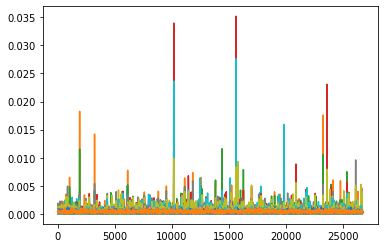

In [ ]:
ax = factors_normalized.plot(legend=False)

Joint distribution

In [ ]:
joint_dist = pd.DataFrame()
i = 0
while i < factors_len-1: 
  if i == 0: 
    joint_dist['normalized'] = factors_normalized[factors_normalized.columns[i]] 
    joint_dist['unnormalized'] =  factors_unnormalized[factors_unnormalized.columns[i]]
  
  joint_dist['normalized'] = joint_dist['normalized'] + factors_normalized[factors_normalized.columns[i]] 
  joint_dist['unnormalized'] = joint_dist['unnormalized'] + factors_unnormalized[factors_unnormalized.columns[i]]
  i=i+1

#the data is crazy big
joint_dist['unnormalized'] = joint_dist['unnormalized'] / 1e+16

#add a label
joint_dist['label'] = label
joint_dist

,normalized,unnormalized,label
3,0.033349,0.001660,resnet
6,0.033992,0.000992,chexnet
13,0.032163,0.023960,unet
50,0.026482,0.001487,chexnet
80,0.036967,0.000875,resnet
...,...,...,...
26646,0.036805,0.001339,chexnet
26652,0.034722,0.000540,chexnet
26665,0.029070,0.004712,chexnet
26674,0.034543,0.010846,unet


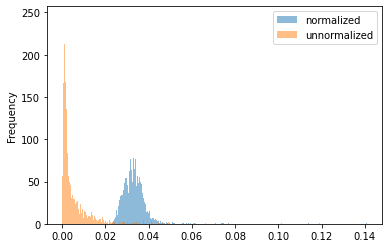

In [ ]:
ax = joint_dist.plot.hist(bins=500, alpha=0.5)

#Machine Learning

###Naive Bayes Classifier

In [ ]:
# load libaries
import numpy as np
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Feature Variables 
features = joint_dist[{'normalized', 'unnormalized'}]

In [ ]:
# Target/Dependent Variable - labels
target = joint_dist['label']

In [ ]:
# Train the Model
model = GaussianNB()
fittedModel = model.fit(features, target)

###Prediction

In [ ]:
import random
from collections import Counter

In [ ]:
#print(random.randint(0,9))
guess = []
#Problem - What are Labels if normalized is x and unnormalized is y?
for x in range(10000): 
  guess.append([random.uniform(0,0.14), random.uniform(0,0.12)])


In [ ]:
# Predict Gender
prediction = fittedModel.predict(guess)

In [ ]:
#output
#print("Labels are:" ,(prediction))

In [ ]:
Counter(prediction)

Counter({'chexnet': 541, 'cnn': 58, 'resnet': 3674, 'unet': 5727})